In [30]:
import re
import itertools
from collections import Counter
import pandas as pd

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wuga/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/wuga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Constant

In [2]:
itemID = 'beer/name'
userID = 'user/profileName'
rating = 'review/overall'
reviewText = 'review/text'
dataPath = 'data/beer/advocate/'
dataName = 'RefinedRawData.csv'

## Load Data

In [51]:
df = pd.read_csv(dataPath+dataName, index_col=0)
df.head()

,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName
0,5.0,Sausa Weizen,Hefeweizen,1.5,A lot of foam. But a lot.\tIn the smell some b...,1234817823,stcules
1,6.2,Red Moon,English Strong Ale,3.0,"Dark red color, light beige foam, average.\tIn...",1235915097,stcules
2,6.5,Black Horse Black Beer,Foreign / Export Stout,3.0,"Almost totally black. Beige foam, quite compac...",1235916604,stcules
3,5.0,Sausa Pils,German Pilsener,3.0,"Golden yellow color. White, compact foam, quit...",1234725145,stcules
4,7.7,Cauldron DIPA,American Double / Imperial IPA,4.0,"According to the website, the style for the Ca...",1293735206,johnmichaelsen


In [52]:
len(df)

1586614

In [53]:
df = df[:100000]

In [61]:
100000.0/(df[userID].nunique()*df[itemID].nunique())

0.002269034934061845

## Vectorize

In [62]:
tokenizer = Tokenizer()
df[reviewText] = df[reviewText].apply(lambda x: str(x).replace('\t', ' '))
text = df[reviewText].tolist()
# tokenizer.fit_on_texts(text)
# df['vector'] = tokenizer.texts_to_sequences(text)

In [63]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
#df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [65]:
#get english stopwords
en_stopwords = set(stopwords.words('english'))

#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace() or word in string.punctuation:
            return False
    for word in ngram:
        if word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    ins = ('IN','TO')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    
    if len(tags) == 2:
        if tags[0][1] in acceptable_types and tags[1][1] in second_type:
            return True
        else:
            return False
    else:
        if tags[0][1] in acceptable_types and tags[2][1] in acceptable_types:
            return True
        else:
            return False
        

In [66]:
stemmer = SnowballStemmer("english")
token_list = (df[reviewText]
              .apply(lambda x: nltk.word_tokenize(x))
              .apply(lambda x: [stemmer.stem(y) for y in x]).tolist())

bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable = bigramFreqTable[bigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [67]:
bigramFreqTable.head(50)

,ngram,freq
890965,"(white, head)",17919
160803,"(medium, bodi)",13406
187510,"(roast, malt)",10721
19068,"(pint, glass)",9632
224514,"(tan, head)",9272
537188,"(veri, nice)",8651
543489,"(sweet, malt)",7226
946041,"(dark, brown)",6767
235260,"(sierra, nevada)",6744
824331,"(caramel, malt)",6495


In [38]:
# trigrams = nltk.collocations.TrigramAssocMeasures()
# tokens = itertools.chain.from_iterable(token_list)
# trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
# trigram_freq = trigramFinder.ngram_fd.items()

# trigramFreqTable = pd.DataFrame(list(trigram_freq), 
#                                 columns=['ngram','freq']).sort_values(by='freq', ascending=False)
# trigramFreqTable = trigramFreqTable[trigramFreqTable.ngram.map(lambda x: rightTypes(x))]

In [40]:
# trigramFreqTable.head(100)

,ngram,freq
1888253,"(light, tan, head)",1569
2183911,"(veri, dark, brown)",1070
1313805,"(sweet, caramel, malt)",942
441381,"(thin, white, head)",939
1957023,"(dark, brown, color)",907
1475335,"(fluffi, white, head)",892
632941,"(light, brown, head)",798
1359562,"(small, white, head)",785
16873,"(dark, roast, malt)",766
1626649,"(finger, white, head)",654


In [15]:
# bigramFinder.apply_freq_filter(100)
# bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
#                               columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

In [68]:
#df_keyphrases = pd.concat([bigramFreqTable[['bigram']].head(50), bigramPMITable[['bigram']].head(50)])
df_keyphrases = bigramFreqTable[['ngram']].head(100)
df_keyphrases['Phrases'] = df_keyphrases['ngram'].apply(lambda x: ' '.join(x))
df_keyphrases = df_keyphrases[['Phrases']].reset_index(drop=True)
keyphrases = df_keyphrases['Phrases'].tolist()

In [69]:
df['keyVector'] = df[reviewText].apply(lambda x: [i for i,key in enumerate(keyphrases) if key in x])

In [70]:
df['UserIndex'] = df[userID].astype('category').cat.rename_categories(range(0, df[userID].nunique()))
df['ItemIndex'] = df[itemID].astype('category').cat.rename_categories(range(0, df[itemID].nunique()))
df['Binary'] = (df[rating] > 3)*1

In [71]:
df_user_name = df[['UserIndex',userID]]
df_item_name = df[['ItemIndex',itemID]]

In [72]:
df = df.drop([itemID, userID, reviewText], axis=1)

## DataFrames

In [78]:
df.head(50)

,beer/ABV,beer/style,review/overall,review/timeUnix,keyVector,UserIndex,ItemIndex,Binary
0,5.0,Hefeweizen,1.5,1234817823,[],10907,2809,0
1,6.2,English Strong Ale,3.0,1235915097,[],10907,2650,0
2,6.5,Foreign / Export Stout,3.0,1235916604,[],10907,463,0
3,5.0,German Pilsener,3.0,1234725145,[],10907,2808,0
4,7.7,American Double / Imperial IPA,4.0,1293735206,"[6, 22, 38, 60, 61, 90]",8278,709,1
5,4.7,Herbed / Spiced Beer,3.0,1325524659,"[0, 53]",9727,669,0
6,4.7,Herbed / Spiced Beer,3.5,1318991115,"[0, 9, 41]",3748,669,1
7,4.7,Herbed / Spiced Beer,3.0,1306276018,"[0, 29, 48, 88]",5098,669,0
8,4.7,Herbed / Spiced Beer,4.0,1290454503,[33],2832,669,1
9,4.7,Herbed / Spiced Beer,4.5,1285632924,"[12, 45, 82]",5245,669,1


In [74]:
df_word_index.head()

,word,index
0,fawn,32712
1,hoppinglight,39925
2,piazza's,36031
3,lagermalt,51046
4,woods,3775


In [75]:
df_keyphrases.head()

,Phrases
0,white head
1,medium bodi
2,roast malt
3,pint glass
4,tan head


In [76]:
df_user_name.head()

,UserIndex,user/profileName
0,10907,stcules
1,10907,stcules
2,10907,stcules
3,10907,stcules
4,8278,johnmichaelsen


In [77]:
df_item_name.head()

,ItemIndex,beer/name
0,2809,Sausa Weizen
1,2650,Red Moon
2,463,Black Horse Black Beer
3,2808,Sausa Pils
4,709,Cauldron DIPA


## Statistic

In [79]:
print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(df['Binary'].tolist())))

Number of User: 11950
Number of Item: 3688
Number of Positive Review: 85378


In [81]:
review_lengths = df.keyVector.apply(lambda x: len(x)).tolist()

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


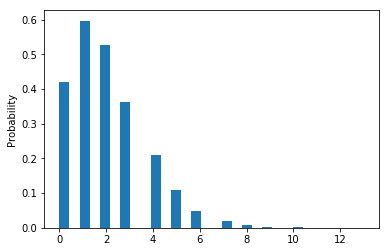

In [82]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(review_lengths, normed=True, bins=30)
plt.ylabel('Probability');

## Save

In [83]:
df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')